In [14]:
#calcuting ekman pumping from wind stress
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
#calcuting ekman pumping from wind stress
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
"""
f = 2 omega sin phi

omega = 2pi radians/day

f = 4 pi radians/day sin phi

ekman = 1/rho f (dtauy/dx - dtaux/dy)
"""

'\nf = 2 omega sin phi\n\nomega = 2pi radians/day\n\nf = 4 pi radians/day sin phi\n\nekman = 1/rho f (dtauy/dx - dtaux/dy)\n'

In [3]:
def coriolis_param(lat):
    day = (24*60*60)-(4*60)# this is 23hrs 56mins
    om = (2*np.pi)/day
    f = 2*om*np.sin(lat * np.pi / 180)
    return f

In [4]:
def ekman(taux, tauy):
    rho = 1026#kgm^-3
    f = coriolis_param(taux.lat)
    dtydx = tauy.differentiate('lon') / (110e3 * np.cos(tauy.lat * np.pi / 180))
    dtxdy = taux.differentiate('lat') / (110e3)
    ek = (1/(rho*f))*(dtydx-dtxdy)
    return ek

In [ ]:
#ekman layer depth formualr
def eld(uwnd, vwnd):
    U10 = np.sqrt((uwnd**2) + (vwnd**2))
    DE = (7.6/np.sqrt(sin(abs(uwnd.lat)))) * U10
    return DE

In [5]:
#load in data
tauu= xr.open_mfdataset('/home/z5113258/Documents/data/CMIP6/ACCESS-CM2/tauuo/*.nc').tauuo.sel(lat=slice(-40,30),lon=slice(30,125))
tauv= xr.open_mfdataset('/home/z5113258/Documents/data/CMIP6/ACCESS-CM2/tauvo/*.nc').tauvo.sel(lat=slice(-40,30),lon=slice(30,125))


In [6]:
#set nan to 0
tauu1 = tauu.fillna(0)
tauv1 = tauv.fillna(0)


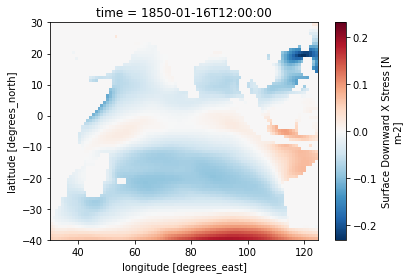

In [7]:
tauu1[0].plot()

In [7]:
test = ekman(tauu1, tauv1)

In [8]:
Wek = ekman(tauu1, tauv1)
Wek_ = Wek.groupby('time.month').mean('time')
Wek_ = Wek_.where((Wek_.lat<-5)|(Wek_.lat>5), 0)

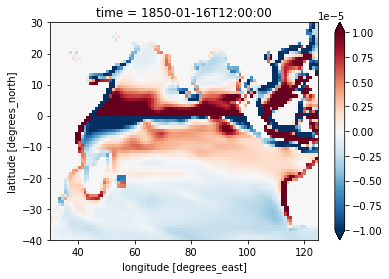

In [9]:
test[:,0].plot(cmap = 'RdBu_r',vmin = -1e-5, vmax = 1e-5)

In [9]:
#calculate w from continuity and look at difference
T = xr.open_mfdataset('/home/z5113258/Documents/data/CMIP6/ACCESS-CM2/THETAO/*.nc').thetao.sel(lat=slice(-40,30),lon=slice(30,125))
U = xr.open_mfdataset('/home/z5113258/Documents/data/CMIP6/ACCESS-CM2/UO/*.nc').uo.sel(lat=slice(-40,30),lon=slice(30,125))
V = xr.open_mfdataset('/home/z5113258/Documents/data/CMIP6/ACCESS-CM2/VO/*.nc').vo.sel(lat=slice(-40,30),lon=slice(30,125))
#W = xr.open_mfdataset('/home/z5113258/Documents/data/CMIP6/ACCESS-CM2/WO/*.nc').wo.sel(lat=slice(-40,30),lon=slice(30,125))
Q = xr.open_mfdataset('/home/z5113258/Documents/data/CMIP6/ACCESS-CM2/HFDS/*.nc').hfds.sel(lat=slice(-40,30),lon=slice(30,125))
#get only to 50m
T = T[:,:5]
U = U[:,:5]
V = V[:,:5]
#W = W[:,4]
#now put lat lon of uvw to T
#U = U.assign_coords({'lat': T.lat, 'lon': T.lon})
#V = V.assign_coords({'lat': T.lat, 'lon': T.lon})
U = U.fillna(0)
V = V.fillna(0)
#W = W.assign_coords({'lat': T.lat, 'lon': T.lon})
#rename lev coord to level
T = T.rename({'lev':'level'})
U = U.rename({'lev':'level'})
V = V.rename({'lev':'level'})

In [10]:
#first get dudx and dvdy
dudx = U.differentiate(coord = 'lon') / (110e3 * np.cos(U.lat * np.pi / 180))
dvdy = V.differentiate(coord='lat') / (110e3)


weights = U.level#add a 0m surface layer
wt=np.array([0.])
for i in range(len(weights.values)):
    NW = 2*weights.values[i]-wt[i]
    wt = np.insert(wt,i+1,NW)
thickness = wt[1:]-wt[:-1]
thickness_DA = xr.DataArray(thickness, coords={'level': U.level},
             dims=['level'])
w_list = []
print(thickness_DA.level)


for i, j in enumerate(thickness_DA):
    if i == 0:
        w = (dudx[:,i]*j + dvdy[:,i]*j)
        #add to new DataArray with vertical coords put in
        w = w.assign_coords({'level': thickness_DA.level[i]})
        w_list.append(w)
    else:
        l = (dudx[:,i]*j + dvdy[:,i]*j) + w_list[i-1]
        w = l.assign_coords({'level': thickness_DA.level[i]})
        w_list.append(w)
#now put all layers into one array
w = xr.concat(w_list, dim = 'level')
W = w
W = W[4,:]

<xarray.DataArray 'level' (level: 5)>
array([ 5., 15., 25., 35., 45.])
Coordinates:
  * level    (level) float64 5.0 15.0 25.0 35.0 45.0
Attributes:
    standard_name:  depth
    long_name:      ocean depth coordinate
    units:          m
    positive:       down
    axis:           Z
    bounds:         lev_bnds


In [11]:
W_ = W.groupby('time.month').mean('time')
W_ = W_.where((W_.lat<-5)|(W_.lat>5), 0)

In [12]:
#now plot climatology
def plot_background(ax, i, j):
    #for use with plotting 12 months. need to change 
    ax.set_extent([30., 125., -30., 20.])
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.5)
    ax.add_feature(cfeature.LAND)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5,)
    gl.top_labels = False
    gl.right_labels = False
    if i == 5:
        gl.bottom_labels = True
    else:
        gl.bottom_labels = False
    if j > 0:
        gl.left_labels = False
    return ax
def plot_var(vari, vmin, vmax, name):
    lons = vari.lon
    lats = vari.lat
    fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(10, 15), sharey='all', sharex='all', 
                                 subplot_kw={'projection':ccrs.PlateCarree()})
    for i in range(0,6):

        axes[i, 0].pcolormesh(lons, lats, (vari).sel(month = i+1), cmap = 'RdBu_r', 
                                    vmin = vmin, vmax = vmax, 
                                    transform=ccrs.PlateCarree())
        plot_background(axes[i,0], i, 0)
        mon = i+1
        axes[i, 0].set_title('Month = '+str(mon))
        #2nd collumn
        im = axes[i, 1].pcolormesh(lons, lats, (vari).sel(month = i+7), cmap = 'RdBu_r', 
                                    #colorbar=True, 
                                    vmin = vmin, vmax = vmax, 
                                    transform=ccrs.PlateCarree())
        plot_background(axes[i,1], i, 1)
        mon2 = i+7
        axes[i, 1].set_title('Month = '+str(mon2))
    cbar_ax = fig.add_axes([0.95, 0.45, 0.05, 0.25])
    fig.colorbar(im, cax=cbar_ax)
    axes[0,0].text(1.5,1.3, name, va='bottom', ha='center', fontsize = 'x-large',
            rotation='horizontal', rotation_mode='anchor',
            transform=axes[0,0].transAxes)
    return fig

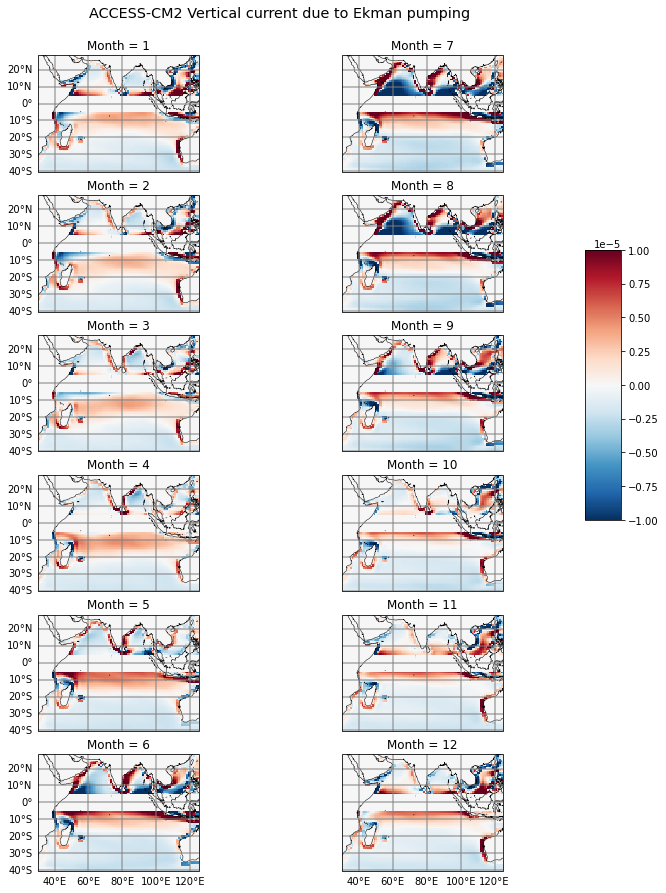

In [15]:
a = plot_var(Wek_, -1e-5, 1e-5, 'ACCESS-CM2 Vertical current due to Ekman pumping')


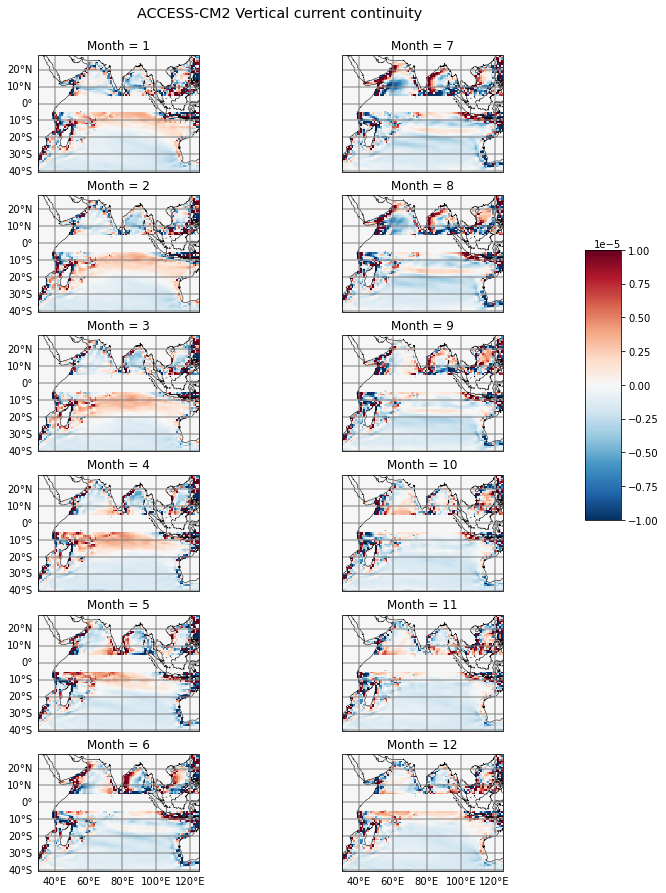

In [16]:
b = plot_var(W_, -1e-5, 1e-5, 'ACCESS-CM2 Vertical current continuity')


Text(0.5, 1.0, 'W current Continuity (ACCESS-CM2)')

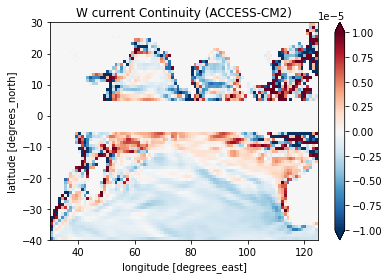

In [12]:
W.where((W.lat<-5)|(W.lat>5), 0)[0].plot(cmap = 'RdBu_r', vmin = -1e-5, vmax = 1e-5)
plt.title('W current Continuity (ACCESS-CM2)')

In [13]:
test1.where((test1.lat<-5)|(test1.lat>5), 0)[:,0].plot(cmap = 'RdBu_r', vmin = -1e-5, vmax = 1e-5)
plt.title('W ekman (ACCESS-CM2)')

NameError: name 'test1' is not defined

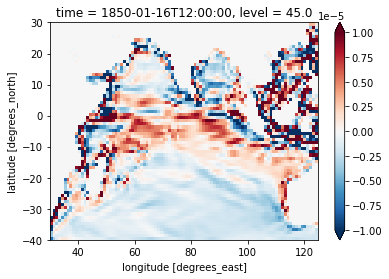

In [72]:
W[0].plot(cmap = 'RdBu_r', vmin = -1e-5, vmax = 1e-5)

In [73]:
W

<xarray.DataArray (time: 1980, lat: 70, lon: 95)>
dask.array<getitem, shape=(1980, 70, 95), dtype=float64, chunksize=(120, 70, 95), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1850-01-16T12:00:00 ... 2014-12-16T12:00:00
  * lon      (lon) float64 30.5 31.5 32.5 33.5 34.5 ... 121.5 122.5 123.5 124.5
  * lat      (lat) float64 -39.5 -38.5 -37.5 -36.5 -35.5 ... 26.5 27.5 28.5 29.5
    level    float64 45.0

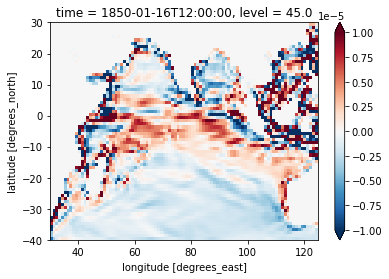

In [54]:
W[0].plot(cmap = 'RdBu_r', vmin = -1e-5, vmax = 1e-5)

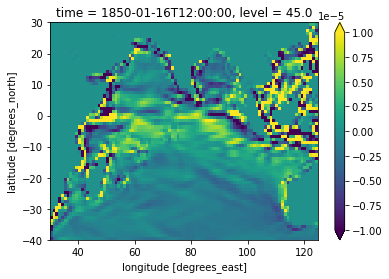

In [53]:
W[0].plot(vmin = -1e-5, vmax = 1e-5)

In [11]:
W1 = w

In [12]:
W1

,Array,Chunk
Bytes,5.13 GB,62.21 MB
Shape,"(5, 1980, 180, 360)","(1, 120, 180, 360)"
Count,1005 Tasks,85 Chunks
Type,float64,numpy.ndarray


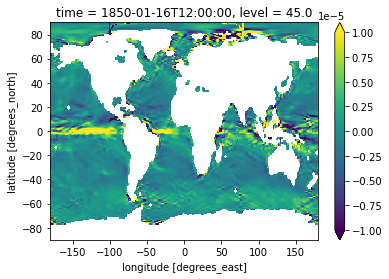

In [13]:
W1[4,0].plot(vmin = -1e-5, vmax = 1e-5)

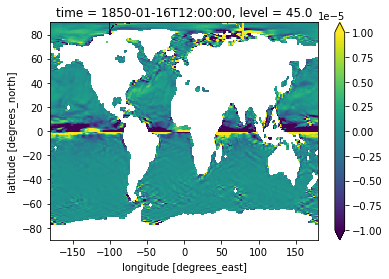

In [14]:
(W-test)[0].plot(vmin = -1e-5, vmax = 1e-5)

In [15]:
tauu[0].values

array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [0.01003187, 0.00977446, 0.00952   , ..., 0.01085204, 0.01057618,
        0.01030238],
       [0.0129576 , 0.01283117, 0.01270569, ..., 0.01336797, 0.01321706,
        0.01308497],
       [0.016888  , 0.01685369, 0.01681967, ..., 0.01699264, 0.01695747,
        0.01692259]], dtype=float32)

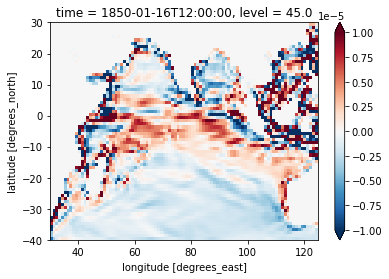

In [75]:
W[0].plot(cmap = 'RdBu_r', vmin = -1e-5, vmax = 1e-5)

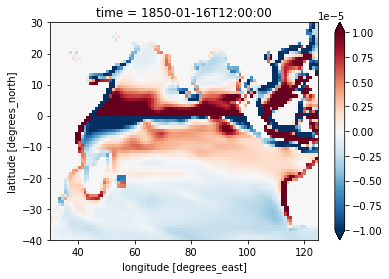

In [74]:
test[:,0].plot(cmap = 'RdBu_r', vmin = -1e-5, vmax = 1e-5)

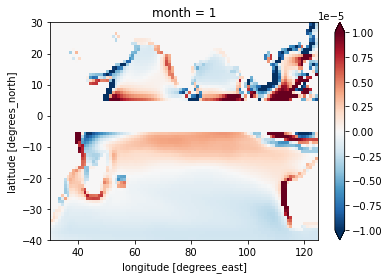

In [69]:
test.groupby('time.month').mean('time').where((test.lat<-5)|(test.lat>5), 0)[:,0].plot(cmap = 'RdBu_r', vmin = -1e-5, vmax = 1e-5)

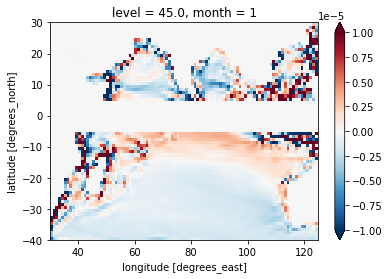

In [68]:
W.groupby('time.month').mean('time').where((W.lat<-5)|(W.lat>5), 0)[0].plot(cmap = 'RdBu_r', vmin = -1e-5, vmax = 1e-5)

In [29]:
test

<xarray.DataArray (lat: 180, time: 1980, lon: 360)>
dask.array<multiply, shape=(180, 1980, 360), dtype=float64, chunksize=(180, 1980, 360), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * time     (time) datetime64[ns] 1850-01-16T12:00:00 ... 2014-12-16T12:00:00
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5

In [31]:
W

<xarray.DataArray (time: 1980, lat: 180, lon: 360)>
dask.array<getitem, shape=(1980, 180, 360), dtype=float64, chunksize=(120, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1850-01-16T12:00:00 ... 2014-12-16T12:00:00
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
    level    float64 45.0

In [118]:
#laod in EC_EARTH daat
#calculate w from continuity and look at difference
T = xr.open_mfdataset('/home/z5113258/Documents/data/CMIP6/EC-Earth3/lev_int/THETAO/*.nc').thetao.sel(lat=slice(-40,30),lon=slice(30,125))
U = xr.open_mfdataset('/home/z5113258/Documents/data/CMIP6/EC-Earth3/lev_int/UO/*.nc').uo.sel(lat=slice(-40,30),lon=slice(30,125))
V = xr.open_mfdataset('/home/z5113258/Documents/data/CMIP6/EC-Earth3/lev_int/VO/*.nc').vo.sel(lat=slice(-40,30),lon=slice(30,125))
Wo = xr.open_mfdataset('/home/z5113258/Documents/data/CMIP6/EC-Earth3/lev_int/WO/*.nc').wo.sel(lat=slice(-40,30),lon=slice(30,125))
Q = xr.open_mfdataset('/home/z5113258/Documents/data/CMIP6/EC-Earth3/*HFDS.nc').hfds.sel(lat=slice(-40,30),lon=slice(30,125))
#get only to 50m
T = T[:,:5]
U = U[:,:5]
V = V[:,:5]
Wo = W[:,4]
#now put lat lon of uvw to T
U = U.assign_coords({'lat': T.lat, 'lon': T.lon})
V = V.assign_coords({'lat': T.lat, 'lon': T.lon})
U = U.fillna(0)
V = V.fillna(0)
Wo = W.assign_coords({'lat': T.lat, 'lon': T.lon})
#rename lev coord to level
T = T.rename({'lev':'level'})
U = U.rename({'lev':'level'})
V = V.rename({'lev':'level'})

In [106]:
dudx = U.differentiate(coord = 'lon') / (110e3 * np.cos(U.lat * np.pi / 180))
dvdy = V.differentiate(coord='lat') / (110e3)


weights = U.level#add a 0m surface layer
wt=np.array([0.])
for i in range(len(weights.values)):
    NW = 2*weights.values[i]-wt[i]
    wt = np.insert(wt,i+1,NW)
thickness = wt[1:]-wt[:-1]
thickness_DA = xr.DataArray(thickness, coords={'level': U.level},
             dims=['level'])
w_list = []
print(thickness_DA.level)


for i, j in enumerate(thickness_DA):
    if i == 0:
        w = (dudx[:,i]*j + dvdy[:,i]*j)
        #add to new DataArray with vertical coords put in
        w = w.assign_coords({'level': thickness_DA.level[i]})
        w_list.append(w)
    else:
        l = (dudx[:,i]*j + dvdy[:,i]*j) + w_list[i-1]
        w = l.assign_coords({'level': thickness_DA.level[i]})
        w_list.append(w)
#now put all layers into one array
w = xr.concat(w_list, dim = 'level')
W = w
W = W[4,:]

<xarray.DataArray 'level' (level: 5)>
array([ 5., 15., 25., 35., 45.])
Coordinates:
  * level    (level) float64 5.0 15.0 25.0 35.0 45.0
Attributes:
    standard_name:  depth
    long_name:      ocean depth coordinate
    units:          m
    positive:       down
    axis:           Z


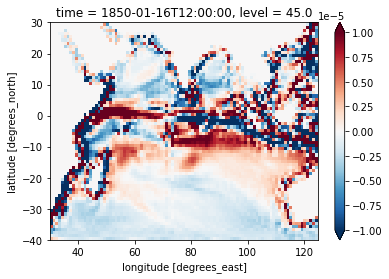

In [121]:
w[4,0].plot(cmap = 'RdBu_r', vmin = -1e-5, vmax = 1e-5)
#plt.title('W current from continuity (EC-Earth)')

Text(0.5, 1.0, 'W current variable (EC-Earth)')

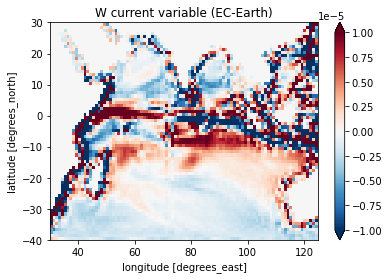

In [122]:
Wo[0].plot(cmap = 'RdBu_r', vmin = -1e-5, vmax = 1e-5)
plt.title('W current variable (EC-Earth)')

In [89]:
Wo

<xarray.DataArray (time: 1980, lat: 70, lon: 95)>
dask.array<getitem, shape=(1980, 70, 95), dtype=float64, chunksize=(12, 70, 95), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1850-01-16T12:00:00 ... 2014-12-16T12:00:00
  * lon      (lon) float64 30.5 31.5 32.5 33.5 34.5 ... 121.5 122.5 123.5 124.5
  * lat      (lat) float64 -39.5 -38.5 -37.5 -36.5 -35.5 ... 26.5 27.5 28.5 29.5
    level    float64 45.0

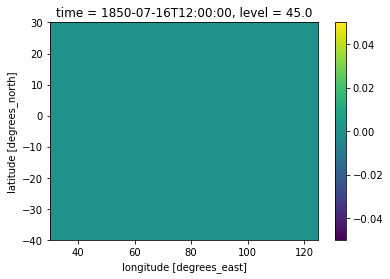

In [112]:
(W-Wo)[6].plot()

In [124]:
tauu= xr.open_mfdataset('/home/z5113258/Documents/data/CMIP6/EC-Earth3//tauuo/*.nc').tauuo.sel(lat=slice(-40,30),lon=slice(30,125))
tauv= xr.open_mfdataset('/home/z5113258/Documents/data/CMIP6/EC-Earth3//tauvo/*.nc').tauvo.sel(lat=slice(-40,30),lon=slice(30,125))
tauu1 = tauu.fillna(0)
tauv1 = tauv.fillna(0)

In [125]:
ec_ek = ekman(tauu1, tauv1)

Text(0.5, 1.0, 'W ekman (EC-Earth)')

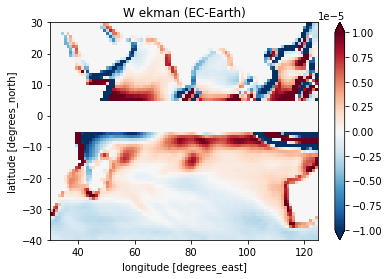

In [131]:
ec_ek.where((ec_ek.lat<-5)|(ec_ek.lat>5), 0)[:,0].plot(cmap = 'RdBu_r', vmin = -1e-5, vmax = 1e-5)
plt.title('W ekman (EC-Earth)')

Text(0.5, 1.0, 'W current variable (EC-Earth)')

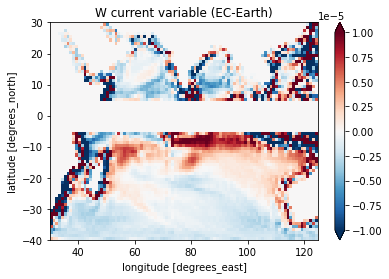

In [133]:
Wo.where((Wo.lat<-5)|(Wo.lat>5), 0)[0].plot(cmap = 'RdBu_r', vmin = -1e-5, vmax = 1e-5)
plt.title('W current variable (EC-Earth)')